In [ ]:
# default_exp funcs.file_io

In [ ]:
%load_ext autoreload
%autoreload 2

# File handling

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
from tifffile import imread
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.psf import crop_psf

In [ ]:
#export
def tiff_imread(path):
    '''helper function to read tiff file with pathlib object or str'''
    if isinstance(path, str) : return imread(path)
    if isinstance(path, Path): return imread(str(path))

In [ ]:
#export
def load_model_state(model, path, file_name ='model.pkl'):
    model_dict = torch.load(Path(path)/file_name)
    model.load_state_dict(model_dict['state_dict'])
    model.unet.inp_scale = model_dict['scaling'][0]
    model.unet.inp_offset = model_dict['scaling'][1]
    return model

In [ ]:
#export
def simfish_to_df(sim_file, px_size=np.array([100.,100.,300.]), frame_idx=0):
    
    yxz = []
    with open(sim_file) as f:
        read = False
        for line in f:
            if 'Pos_Y' in line: 
                read = True
                continue
            if 'SPOTS_END' in line: break
            if read: yxz.append([float(s) for s in line.split()[:3]])

    yxz = np.array(yxz)/px_size
    loc_idx = np.arange(len(yxz))
    
    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': frame_idx,
                       'x': yxz[:,1]*px_size[0],
                       'y': yxz[:,0]*px_size[1], 
                       'z': yxz[:,2]*px_size[2], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})

    return df   

#export
def load_sim_fish(basedir, mrna_lvl=200, shape='cell3D', exp_strength='strong'):
    
    spec_dir = f'/mRNAlevel_200/{shape}/{exp_strength}/'
#     file_name = f'/w1_HelaKyoto_Gapdh_2597_p01_cy3__Cell_CP_{cell_cp}__{shape}__{nr}'
    img_path = glob.glob(basedir + spec_dir + 'w1*.tif')[0]
    print(img_path)
    img = load_tiff_image(img_path)
    gt_df = simfish_to_df(glob.glob(basedir + spec_dir + '*.txt')[0])
    fq_nog_df = simfish_to_df(glob.glob(basedir + '/_results_detection/' + spec_dir + '/results_noGMM/' + 'w1*.txt')[0])
    fq_gmm_df = simfish_to_df(glob.glob(basedir + '/_results_detection/' + spec_dir + '/results_GMM/' + 'w1*.txt')[0])
    
    return img, gt_df, fq_nog_df, fq_gmm_df

In [ ]:
#export
def load_tiff_image(image_path: str):
    "Given tiff stack path, loads the stack and converts it to a tensor. If necessary adds a dimension for the batch size"
    image_path = Path(image_path)
    image  = torch.tensor(tiff_imread(image_path).astype('float32'))
    if len(image.shape) == 3: image.unsqueeze_(0)
    assert len(image.shape) == 4, 'the shape of image must be 4, (1, Z, X, Y)'
    #removing minum values of the image
    return image

In [ ]:
#export
def load_psf_noise_micro(cfg):
    psf_state = torch.load(cfg.data_path.psf_path)
        
    psf = hydra.utils.instantiate(cfg.PSF, size_zyx=psf_state['psf_volume'].shape[-3:])
    psf.load_state_dict(psf_state)
    
    if cfg.microscope.psf_extent_zyx:
        psf = crop_psf(psf,cfg.microscope.psf_extent_zyx)

    noise = hydra.utils.instantiate(cfg.noise)
    micro = Microscope(parametric_psf=[psf], noise=noise, multipl=cfg.microscope.multipl).cuda()
    
    return psf, noise, micro

In [ ]:
cfg = OmegaConf.load(default_conf)
psf, noise, micro = load_psf_noise_micro(cfg)

/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


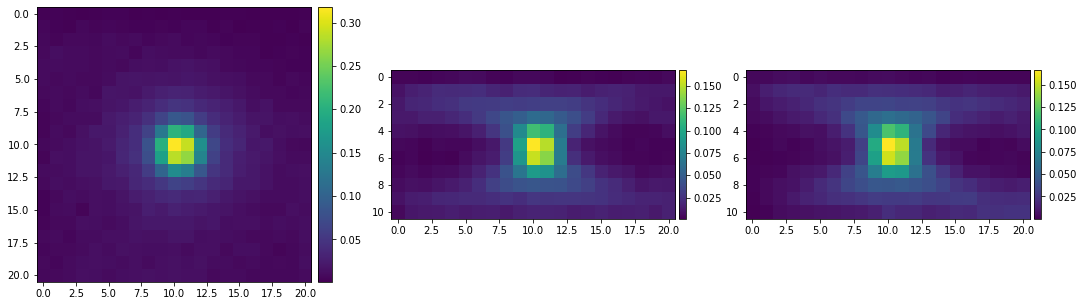

In [ ]:
from decode_fish.funcs.plotting import *
plot_3d_projections(psf.psf_volume[0])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train_sl.ipynb.
Converted 14_train_ae.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted index.ipynb.
